<a href="https://colab.research.google.com/github/singhnidh/Plant-disease-detection-using-Deep-Learning-and-Machine-Vision/blob/main/2_FINAL_VGG16_FT_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

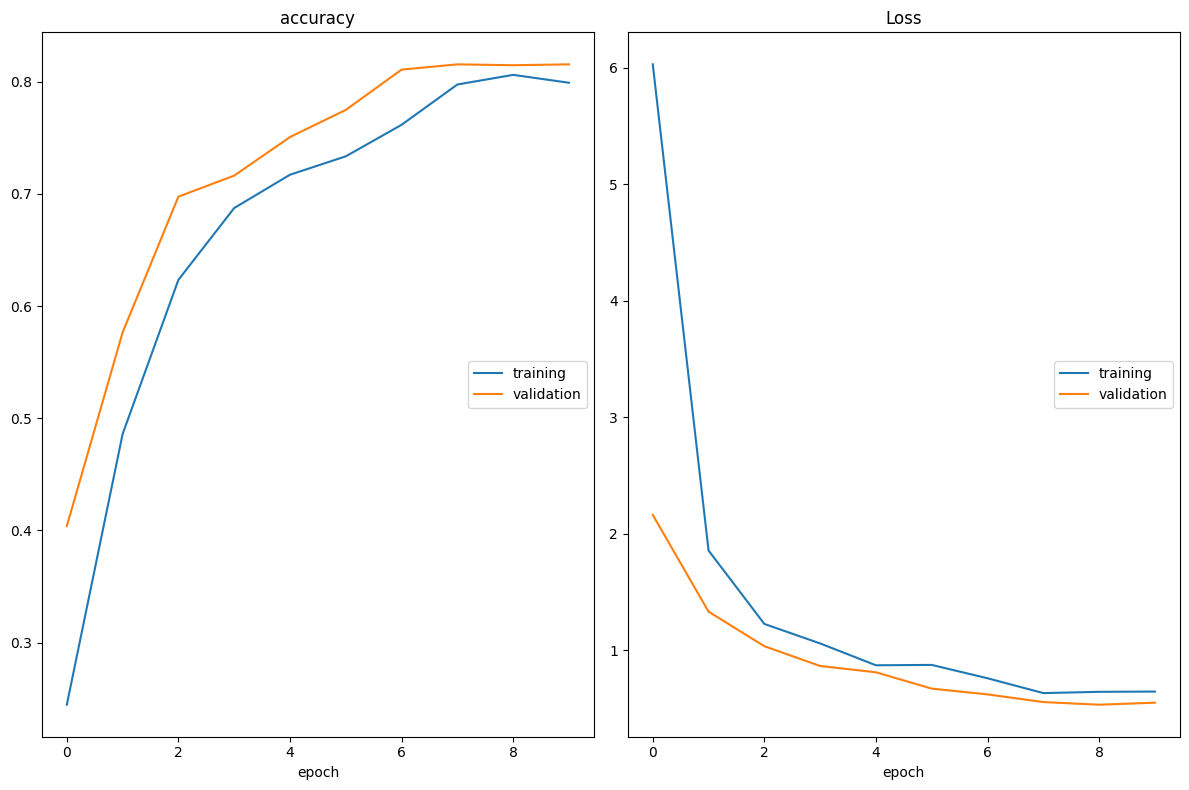

accuracy
	training         	 (min:    0.245, max:    0.806, cur:    0.799)
	validation       	 (min:    0.404, max:    0.816, cur:    0.816)
Loss
	training         	 (min:    0.634, max:    6.029, cur:    0.647)
	validation       	 (min:    0.534, max:    2.162, cur:    0.551)
20/20 [==============================] - 1560s 80s/step - loss: 0.6467 - accuracy: 0.7992 - val_loss: 0.5514 - val_accuracy: 0.8156


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as n
!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback


BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset')

train_data_dir = download_dir/' dataset_original'
test_data_dir = download_dir/' Augmented Dataset'

class_subset = os.listdir(download_dir/' dataset_original')
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

#Using Pre-trained Layers for Feature Extraction

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

#Training Without Fine-Tuning

input_shape = (224, 224, 3)
n_classes=20

n_steps =20 # traingen.samples // BATCH_SIZE
n_val_steps =20 # validgen.samples // BATCH_SIZE
n_epochs = 10
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/vggnet16_t2_another_2.h5',
                                  save_best_only=True,
                                  verbose=1)
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Use a smaller learning rate
optim_2 = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_2 = create_model(input_shape, n_classes, optim_2, fine_tune=2)
plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_2.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)
filepath="/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/vggnet16_t2_another_2.h5"
vgg_model_2.save(filepath)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

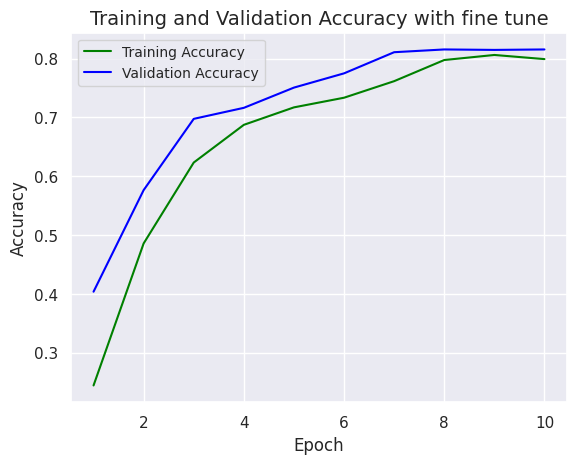

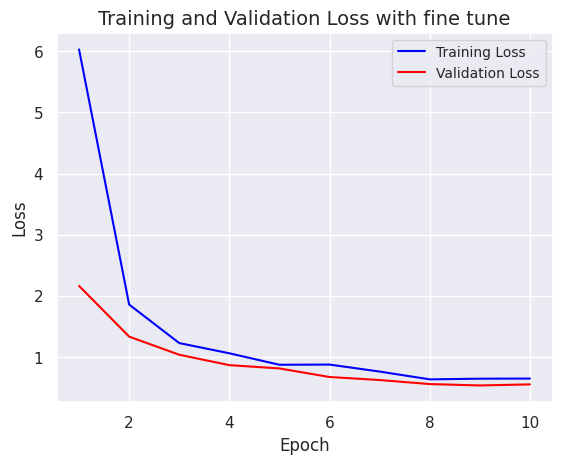

In [ ]:
sns.set()
font_scale=0.5
acc = vgg_ft_history.history['accuracy']
val_acc = vgg_ft_history.history['val_accuracy']
loss = vgg_ft_history.history['loss']
val_loss = vgg_ft_history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy with fine tune',fontsize=14)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(fontsize=10)

plt.figure()
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss with fine tune',fontsize=14)
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend(fontsize=10)

plt.show()


In [ ]:

# Generate predictions
#vgg_model_2.load_weights(filepath) # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds_2 = vgg_model_2.predict(testgen)
vgg_pred_classes_2 = np.argmax(vgg_preds_2, axis=1)
from sklearn.metrics import accuracy_score
vgg_acc_2 = accuracy_score(true_classes, vgg_pred_classes_2)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_2 * 100))

10472/10472 [==============================] - 6499s 621ms/step
VGG16 Model Accuracy with Fine-Tuning: 79.27%


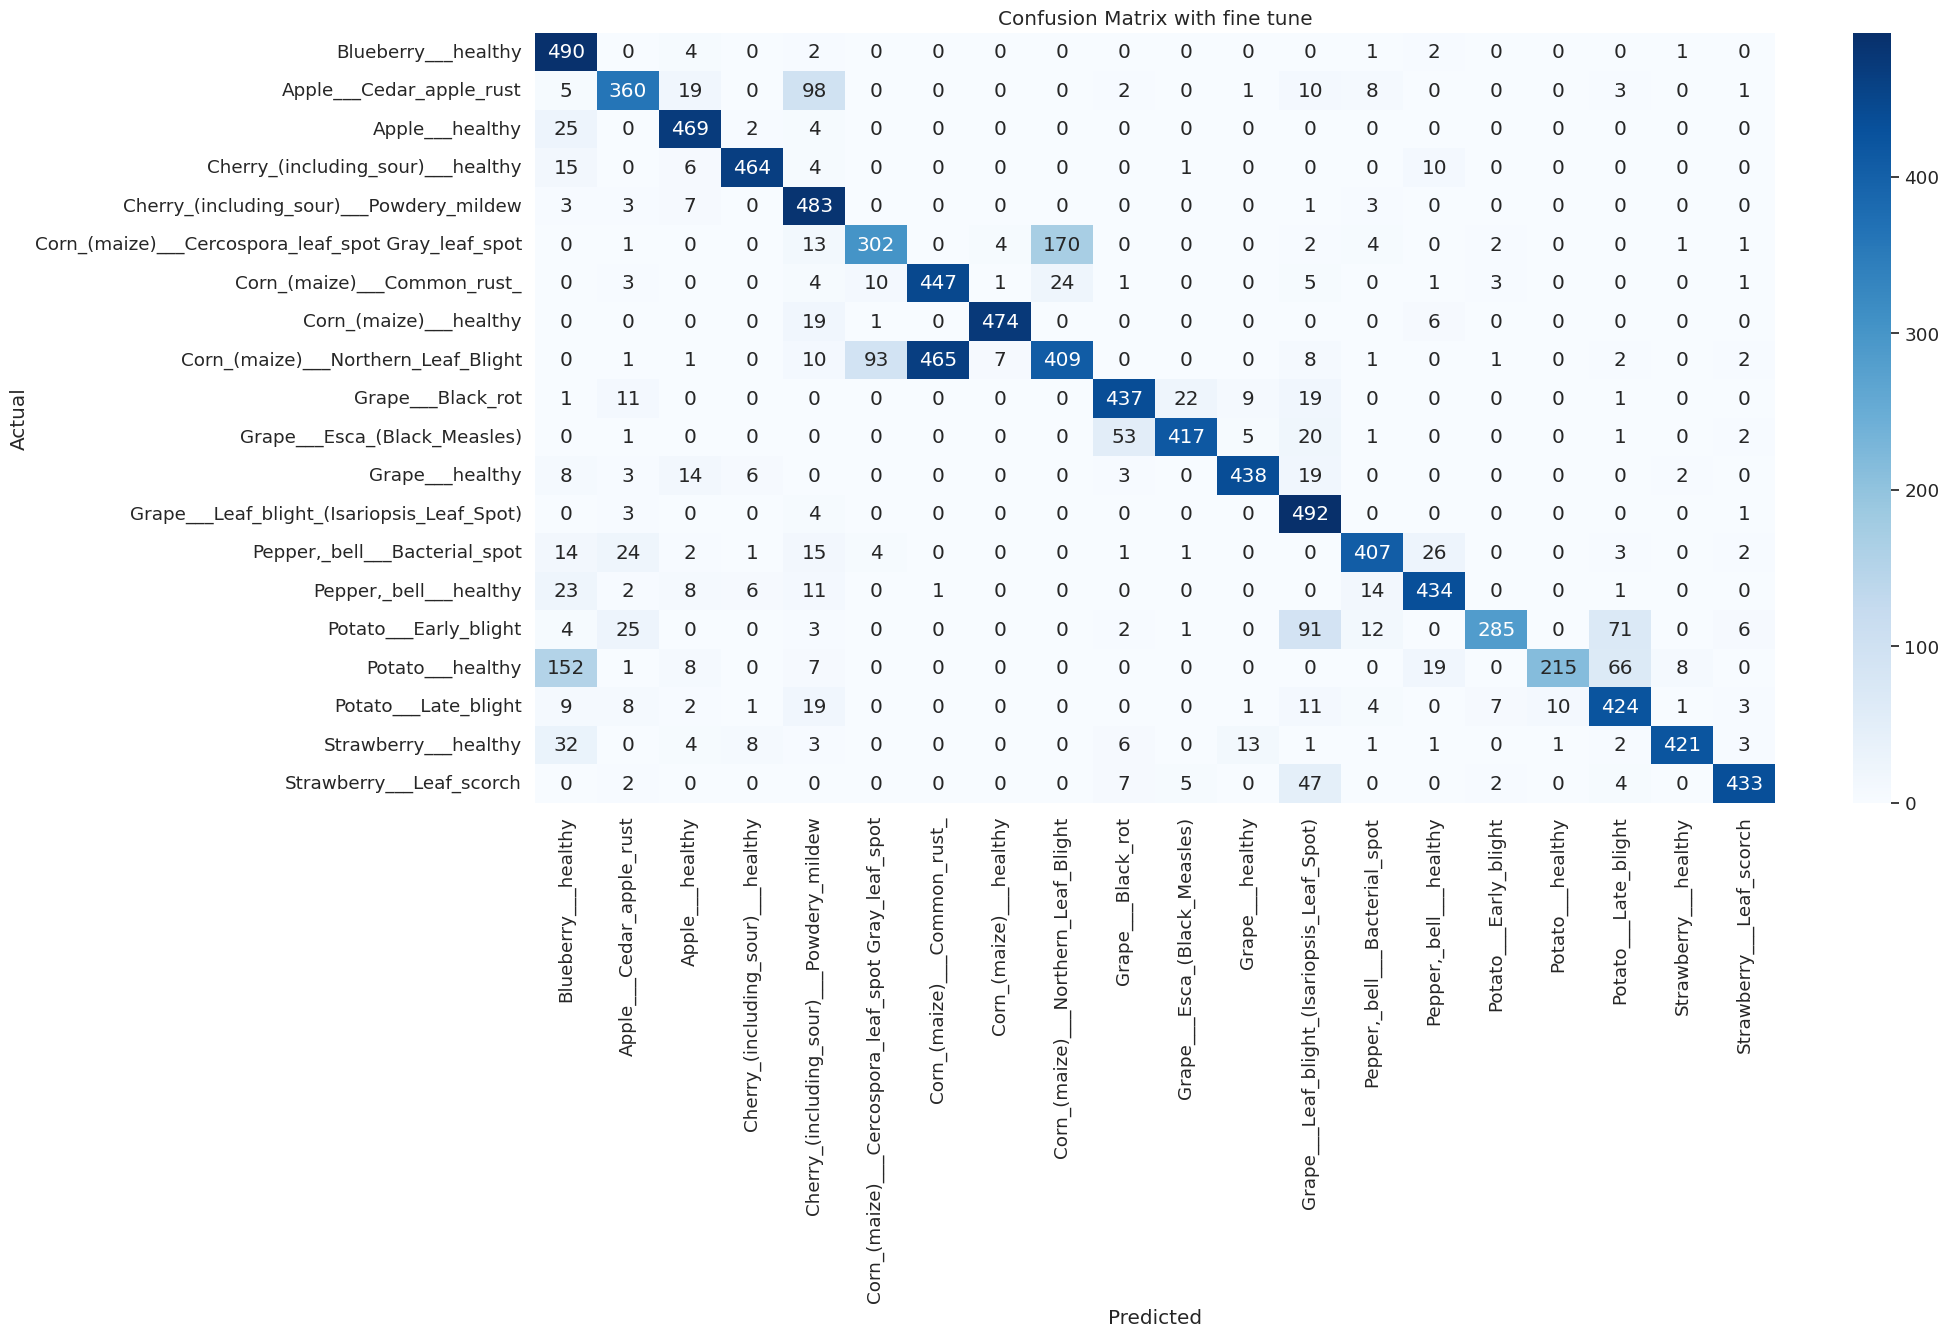

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(true_classes, vgg_pred_classes_2)
# Define class names if you have them
class_names = testgen.class_indices.keys()
# Create a heatmap
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


In [ ]:
# Predict on the validation set
#y_pred = vgg_model_ft.predict(testgen)
y_pred = vgg_preds_2
y_true = testgen.classes

# Convert class probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
cm = confusion_matrix(y_true, y_pred_classes)
classification_rep = classification_report(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Display classification report, precision, recall, and F1 score
print("\nClassification Report:")
print(classification_rep)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


Confusion Matrix:
[[490   0   4   0   2   0   0   0   0   0   0   0   0   1   2   0   0   0
    1   0]
 [  5 360  19   0  98   0   0   0   0   2   0   1  10   8   0   0   0   3
    0   1]
 [ 25   0 469   2   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 15   0   6 464   4   0   0   0   0   0   1   0   0   0  10   0   0   0
    0   0]
 [  3   3   7   0 483   0   0   0   0   0   0   0   1   3   0   0   0   0
    0   0]
 [  0   1   0   0  13 302   0   4 170   0   0   0   2   4   0   2   0   0
    1   1]
 [  0   3   0   0   4  10 447   1  24   1   0   0   5   0   1   3   0   0
    0   1]
 [  0   0   0   0  19   1   0 474   0   0   0   0   0   0   6   0   0   0
    0   0]
 [  0   1   1   0  10  93 465   7 409   0   0   0   8   1   0   1   0   2
    0   2]
 [  1  11   0   0   0   0   0   0   0 437  22   9  19   0   0   0   0   1
    0   0]
 [  0   1   0   0   0   0   0   0   0  53 417   5  20   1   0   0   0   1
    0   2]
 [  8   3  14   6   0   0   0   0   0   3   0 4

In [ ]:
print(vgg_ft_history)